In [27]:
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam # Adam is just like SGD but faster
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import OneHotEncoder
import tqdm
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import seaborn as sns  # Import Seaborn for the heatmap
import threading
import concurrent.futures
import sys
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import os
from collections import namedtuple
from sklearn.metrics import classification_report
from IPython.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


# Helper Functions

In [28]:
def print_df_with_all_rows(df):
    pd.set_option('display.max_rows', None)
    display(df)
    pd.reset_option('display.max_rows')

def print_df_with_all_cols(df):
    pd.set_option('display.max_columns', None)
    display(df)
    pd.reset_option('display.max_columns')
    
def print_all_df(df):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    display(df)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')

def summary_a_df(df):
    # Summary statistics for numerical columns
    numerical_summary = df.describe()

    # Summary statistics for string columns
    string_summary = df.describe(include=['object'])

    # Combine the summaries
    summary = pd.concat([numerical_summary, string_summary], axis=1)

    # Display the summary in table-like format
    display(summary.style.set_caption("Summary Statistics"))
    
def remove_nan_and_inf(df):
    df = df.dropna(how='any', axis=0, inplace=False)
    inf_condition = (df == np.inf).any(axis=1)
    df = df[~inf_condition]
    return df

def count_labels(df):
    label_counts = df[' Label'].value_counts()

    # Convert the value counts into a DataFrame for better formatting
    label_counts_df = pd.DataFrame(label_counts)

    # Rename the column to make it more descriptive
    label_counts_df.columns = ['Count']

    # Print the table
    display(label_counts_df)
    
def label_coding(df, label):
    label_encoder = LabelEncoder()
    df[label] = label_encoder.fit_transform(df[label])
    return df

# Make csv File Training and Test set

In [29]:
# Define a named tuple to represent the return type
TrainTestSplit = namedtuple('TrainTestSplit', 
                            ['X_train', 'X_test', 'y_train', 'y_test', 'categories_as_list'])
def get_train_and_test(dfs):
    data = pd.concat(dfs, ignore_index=True)
    data = remove_nan_and_inf(data)
    
    # summary_a_df(data)
    
    # drop some unused feature
    data = data.drop(columns='Flow ID')
    data = data.drop(columns=' Timestamp')

    # do label encoding to some feature
    label_encoder = LabelEncoder()
    data[" Source IP"] = label_encoder.fit_transform(data[" Source IP"])
    data[" Source Port"] = label_encoder.fit_transform(data[" Source Port"])
    data[" Destination IP"] = label_encoder.fit_transform(data[" Destination IP"])
    data[" Destination Port"] = label_encoder.fit_transform(data[" Destination Port"])
    # data[" Timestamp"] = label_encoder.fit_transform(data[" Timestamp"])

    # Shuffle all the rows of the DataFrame
    # data = data.sample(frac=1).reset_index(drop=True)
    # summary_a_df(data)
    
    ### get `X` from `data`
    X = data.drop(columns=' Label')
    X = X.values.reshape(-1, X.shape[1]).astype('float32')
    standardizer = preprocessing.StandardScaler()
    X = standardizer.fit_transform(X)
    
    ### get `y` from `data`
    y = data.iloc[:, -1:]
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y)
    y = ohe.transform(y)
    categories = ohe.categories_
    categories_as_list = []
    for i, label in enumerate(categories[0]):
        categories_as_list.append(label)
        
    X = torch.tensor(X, dtype=torch.float32).to(DEVICE)
    y = torch.tensor(y, dtype=torch.float32).to(DEVICE)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.67, shuffle=True)
    return TrainTestSplit(X_train, X_test, y_train, y_test, categories_as_list)

In [30]:
dataset_dir = './TrafficLabelling/'
def read_csv(csv_file):
    file_path = os.path.join(dataset_dir, csv_file)
    # Try different encodings until the file is successfully read
    df = None
    for encoding in ['utf-8', 'latin1', 'ISO-8859-1', 'windows-1252']:
        try:
            df = pd.read_csv(file_path, encoding=encoding)
            break  # Stop trying encodings once the file is successfully read
        except UnicodeDecodeError:
            continue
    return df

def make_label_amount(df, label, amount):
    df = remove_nan_and_inf(df)
    # Filter the DataFrame to select rows with the specified label
    label_rows = df[df[' Label'] == label]
    # Take the first 'amount' rows with the specified label
    df_subset = label_rows.head(amount)
    df_remaining = df[df[' Label'] != label]
    # Concatenate the subset DataFrame with the remaining rows
    df_concatenated = pd.concat([df_remaining, df_subset], ignore_index=True)
    return df_concatenated

# df_Mon  = read_csv("Monday-WorkingHours.pcap_ISCX.csv")

df_Tue  = read_csv("Tuesday-WorkingHours.pcap_ISCX.csv")
df_Tue = make_label_amount(df_Tue, "BENIGN", 9900)
count_labels(df_Tue)

df_Wed  = read_csv("Wednesday-workingHours.pcap_ISCX.csv")
df_Wed = make_label_amount(df_Wed, "BENIGN", 9900)
df_Wed = make_label_amount(df_Wed, "DoS Hulk", 9900)
df_Wed = make_label_amount(df_Wed, "DoS GoldenEye", 9900)
count_labels(df_Wed)

df_Thu1 = read_csv("Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv")
df_Thu2 = read_csv("Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")
df_Thu = pd.concat([df_Thu1, df_Thu2], ignore_index=True)
df_Thu = make_label_amount(df_Thu, "BENIGN", 9900)
count_labels(df_Thu)

# df_Fri1 = read_csv("Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
# df_Fri2 = read_csv("Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
# df_Fri3 = read_csv("Friday-WorkingHours-Morning.pcap_ISCX.csv")
# df_Fri = pd.concat([df_Fri1, df_Fri2, df_Fri3], ignore_index=True)

,Count
Label,
BENIGN,9900
FTP-Patator,7935
SSH-Patator,5897


,Count
Label,
BENIGN,9900
DoS Hulk,9900
DoS GoldenEye,9900
DoS slowloris,5796
DoS Slowhttptest,5499
Heartbleed,11


/tmp/ipykernel_2948260/1389379217.py:8: DtypeWarning: Columns (0,1,3,6,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding=encoding)


,Count
Label,
BENIGN,9900
Web Attack  Brute Force,1507
Web Attack  XSS,652
Infiltration,36
Web Attack  Sql Injection,21


# Function for Training Models

In [31]:
def training_model(model, 
                   train_test,
                   learning_rate=0.0001, n_epochs=300, batch_size=512):
    # get data from train_test
    X_train            = train_test.X_train           
    X_test             = train_test.X_test            
    y_train            = train_test.y_train           
    y_test             = train_test.y_test            
    categories_as_list = train_test.categories_as_list
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # prepare model and training parameters
    batches_per_epoch = len(X_train) // batch_size

    best_acc = - np.inf   # init to negative infinity
    best_weights = None
    train_loss_hist = []
    train_acc_hist = []
    test_loss_hist = []
    test_acc_hist = []
    
    # start training 
    for epoch in range(n_epochs):
        epoch_loss = []
        epoch_acc = []
        # set model in training mode and run through each batch
        model.train()
        # with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        for i in range(batches_per_epoch):
            # take a batch
            start = i * batch_size
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]

            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            # bar.set_postfix(
            #     loss=float(loss),
            #     acc=float(acc)
            # )
        # set model in evaluation mode and run through the test set
        model.eval()
        y_pred = model(X_test)
        ce = loss_fn(y_pred, y_test)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
        ce = float(ce)
        acc = float(acc)
        train_loss_hist.append(np.mean(epoch_loss))
        train_acc_hist.append(np.mean(epoch_acc))
        test_loss_hist.append(ce)
        test_acc_hist.append(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%")
        
    # display result
    # Restore best model
    model.load_state_dict(best_weights)

    # Plot the loss and accuracy
    plt.plot(train_loss_hist, label="train")
    plt.plot(test_loss_hist, label="test")
    plt.xlabel("epochs")
    plt.ylabel("cross entropy")
    plt.legend()
    # plt.savefig('cross_entropy.png')
    plt.show()

    plt.plot(train_acc_hist, label="train")
    plt.plot(test_acc_hist, label="test")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.legend()
    # plt.savefig('accuracy.png')
    plt.show()

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)

    y_pred_classes = torch.argmax(y_pred, dim=1).cpu().numpy()
    y_true_classes = torch.argmax(y_test, dim=1).cpu().numpy()

    from sklearn.metrics import confusion_matrix

    confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)

    # Assuming you have already computed the confusion matrix
    confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)

    # Define your custom class labels
    # class_labels = ['normal', 'tcpfin', 'tcppush', 'tcprst', 'tcpsyn', 'udpflood']
    class_labels = categories_as_list
    # class_labels = [i for i in range(1, 16)]
    # Create a heatmap of the confusion matrix with custom labels
    # categories_as_list = [item for sublist in categories for item in sublist]  # Flatten the categories list
    # class_labels = categories_as_list

    plt.figure(figsize=(16, 12))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                        xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    # plt.savefig('confusion_matrix.png')
    plt.show()
    
    # Calculate the classification report
    report = classification_report(y_true_classes, y_pred_classes, target_names=class_labels, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    display(report_df)


In [32]:
# Mon = get_train_and_test([df_Mon])
Tue = get_train_and_test([df_Tue])
Wed = get_train_and_test([df_Wed])
Thu = get_train_and_test([df_Thu])

# Defining models

In [33]:
### TODO: add argument `num_inputs`
class ANN(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        self.hidden1 = nn.Linear(num_inputs, 50)
        self.hidden2 = nn.Linear(50, 50)
        self.output = nn.Linear(50, num_outputs)
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.output(x)
        return x
ann_Tue = ANN(Tue.X_test.size()[1], len(Tue.categories_as_list)).to(DEVICE)
ann_Wed = ANN(Wed.X_test.size()[1], len(Wed.categories_as_list)).to(DEVICE)
ann_Thu = ANN(Thu.X_test.size()[1], len(Thu.categories_as_list)).to(DEVICE)

class DNN(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        self.hidden1 = nn.Linear(num_inputs, 500)
        self.hidden2 = nn.Linear(500, 500)
        self.hidden3 = nn.Linear(500, 500)
        self.hidden4 = nn.Linear(500, 500)
        self.hidden5 = nn.Linear(500, 500)
        self.hidden6 = nn.Linear(500, 500)
        self.output = nn.Linear(500, num_outputs)
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = F.relu(self.hidden4(x))
        x = F.relu(self.hidden5(x))
        x = F.relu(self.hidden6(x))
        x = self.output(x)
        return x
dnn_Tue = DNN(Tue.X_test.size()[1], len(Tue.categories_as_list)).to(DEVICE)
dnn_Wed = DNN(Wed.X_test.size()[1], len(Wed.categories_as_list)).to(DEVICE)
dnn_Thu = DNN(Thu.X_test.size()[1], len(Thu.categories_as_list)).to(DEVICE)

class MLP(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        self.hidden1 = nn.Linear(num_inputs, 50)
        self.hidden2 = nn.Linear(50, 50)
        self.hidden3 = nn.Linear(50, 50)
        self.output = nn.Linear(50, num_outputs)
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = self.output(x)
        return x
mlp_Tue = MLP(Tue.X_test.size()[1], len(Tue.categories_as_list)).to(DEVICE)
mlp_Wed = MLP(Wed.X_test.size()[1], len(Wed.categories_as_list)).to(DEVICE)
mlp_Thu = MLP(Thu.X_test.size()[1], len(Thu.categories_as_list)).to(DEVICE)

### ANN

Epoch 0 validation: Cross-entropy=1.07, Accuracy=39.7%
Epoch 1 validation: Cross-entropy=1.03, Accuracy=53.6%
Epoch 2 validation: Cross-entropy=0.98, Accuracy=74.0%
Epoch 3 validation: Cross-entropy=0.92, Accuracy=79.9%
Epoch 4 validation: Cross-entropy=0.86, Accuracy=84.8%
Epoch 5 validation: Cross-entropy=0.79, Accuracy=90.3%
Epoch 6 validation: Cross-entropy=0.71, Accuracy=96.2%
Epoch 7 validation: Cross-entropy=0.64, Accuracy=97.3%
Epoch 8 validation: Cross-entropy=0.56, Accuracy=97.7%
Epoch 9 validation: Cross-entropy=0.49, Accuracy=97.7%
Epoch 10 validation: Cross-entropy=0.42, Accuracy=97.8%
Epoch 11 validation: Cross-entropy=0.36, Accuracy=98.1%
Epoch 12 validation: Cross-entropy=0.30, Accuracy=98.2%
Epoch 13 validation: Cross-entropy=0.26, Accuracy=98.2%
Epoch 14 validation: Cross-entropy=0.22, Accuracy=98.2%
Epoch 15 validation: Cross-entropy=0.19, Accuracy=98.3%
Epoch 16 validation: Cross-entropy=0.16, Accuracy=98.3%
Epoch 17 validation: Cross-entropy=0.14, Accuracy=98.4%
Ep

Epoch 156 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 157 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 158 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 159 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 160 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 161 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 162 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 163 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 164 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 165 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 166 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 167 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 168 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 169 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 170 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 171 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 172 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 173 validation: Cross-ent

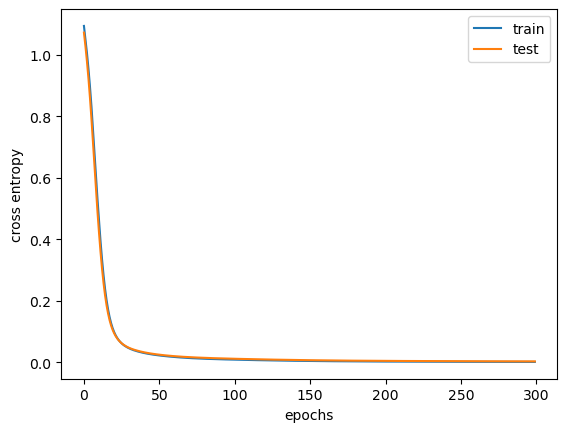

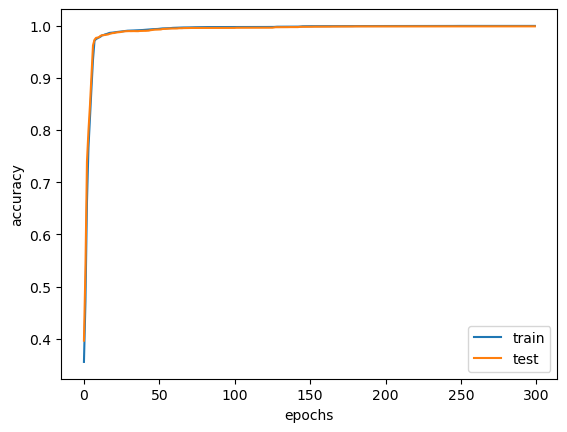

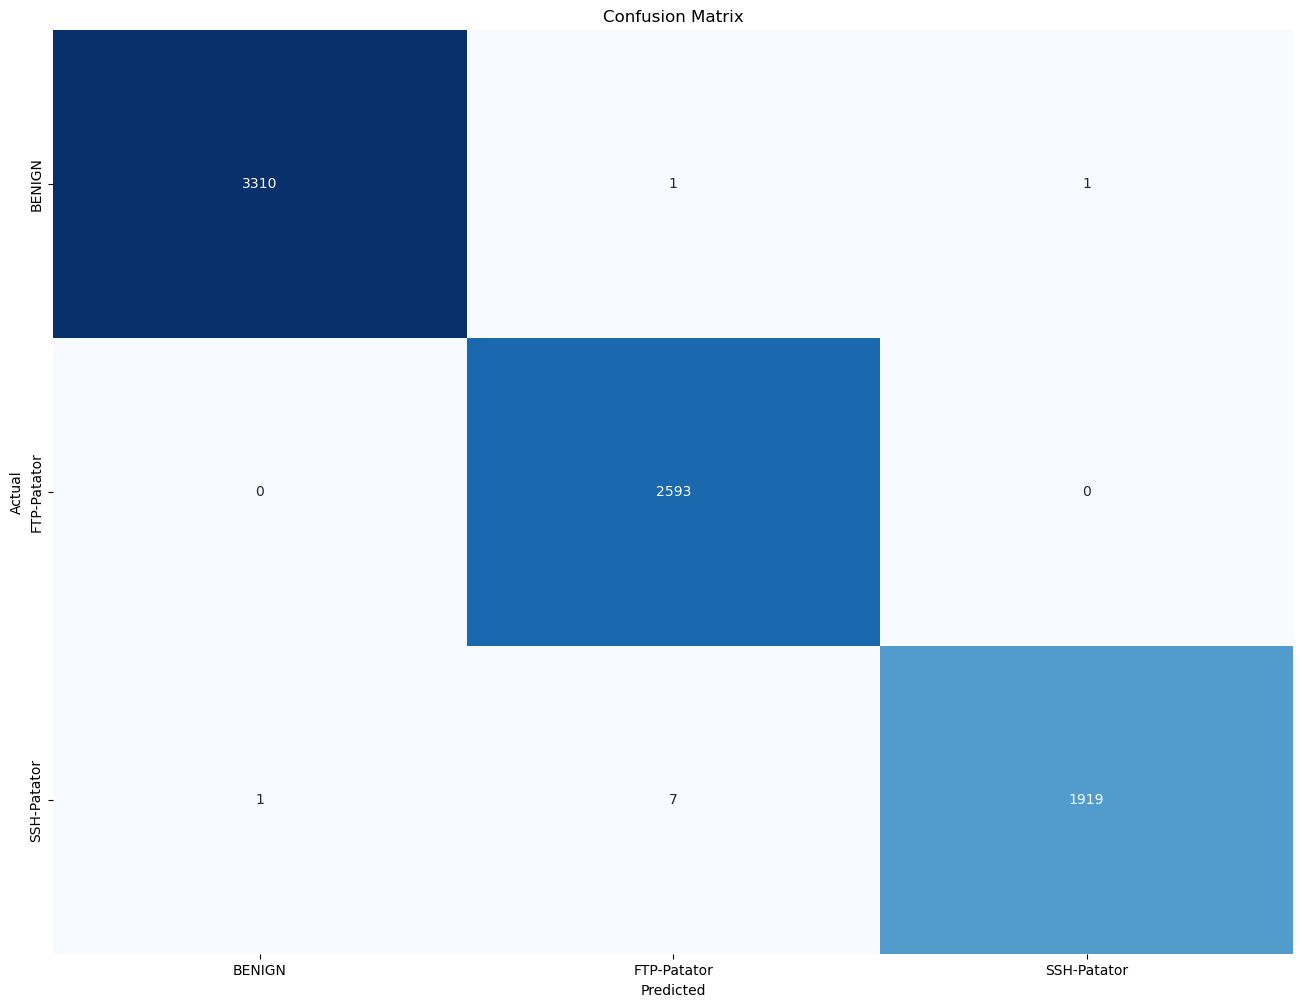

,precision,recall,f1-score,support
BENIGN,0.999698,0.999396,0.999547,3312.000000
FTP-Patator,0.996924,1.000000,0.998460,2593.000000
SSH-Patator,0.999479,0.995848,0.997661,1927.000000
accuracy,0.998723,0.998723,0.998723,0.998723
macro avg,0.998700,0.998415,0.998556,7832.000000
weighted avg,0.998726,0.998723,0.998723,7832.000000


Epoch 0 validation: Cross-entropy=1.70, Accuracy=30.6%
Epoch 1 validation: Cross-entropy=1.61, Accuracy=40.6%
Epoch 2 validation: Cross-entropy=1.48, Accuracy=52.7%
Epoch 3 validation: Cross-entropy=1.32, Accuracy=61.8%
Epoch 4 validation: Cross-entropy=1.13, Accuracy=65.9%
Epoch 5 validation: Cross-entropy=0.94, Accuracy=72.5%
Epoch 6 validation: Cross-entropy=0.78, Accuracy=85.6%
Epoch 7 validation: Cross-entropy=0.65, Accuracy=89.4%
Epoch 8 validation: Cross-entropy=0.53, Accuracy=92.3%
Epoch 9 validation: Cross-entropy=0.44, Accuracy=93.2%
Epoch 10 validation: Cross-entropy=0.37, Accuracy=93.8%
Epoch 11 validation: Cross-entropy=0.31, Accuracy=94.6%
Epoch 12 validation: Cross-entropy=0.27, Accuracy=95.4%
Epoch 13 validation: Cross-entropy=0.24, Accuracy=95.9%
Epoch 14 validation: Cross-entropy=0.21, Accuracy=96.0%
Epoch 15 validation: Cross-entropy=0.19, Accuracy=96.3%
Epoch 16 validation: Cross-entropy=0.17, Accuracy=96.4%
Epoch 17 validation: Cross-entropy=0.15, Accuracy=96.8%
Ep

Epoch 150 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 151 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 152 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 153 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 154 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 155 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 156 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 157 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 158 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 159 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 160 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 161 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 162 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 163 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 164 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 165 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 166 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 167 validation: Cross-ent

Epoch 299 validation: Cross-entropy=0.01, Accuracy=99.8%


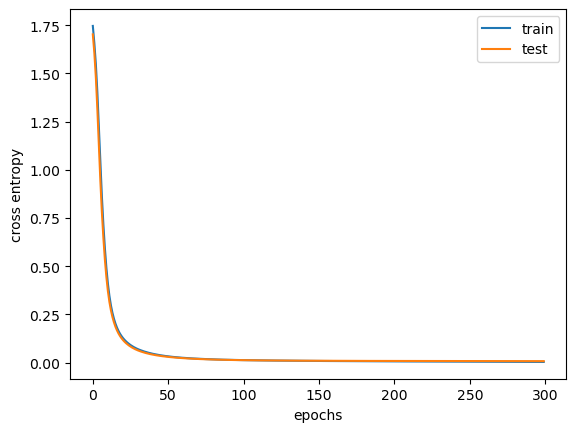

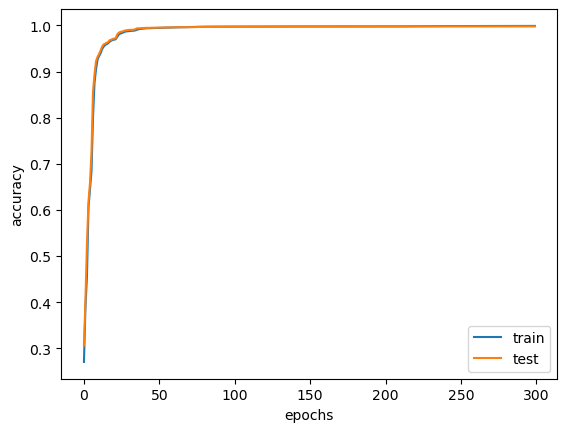

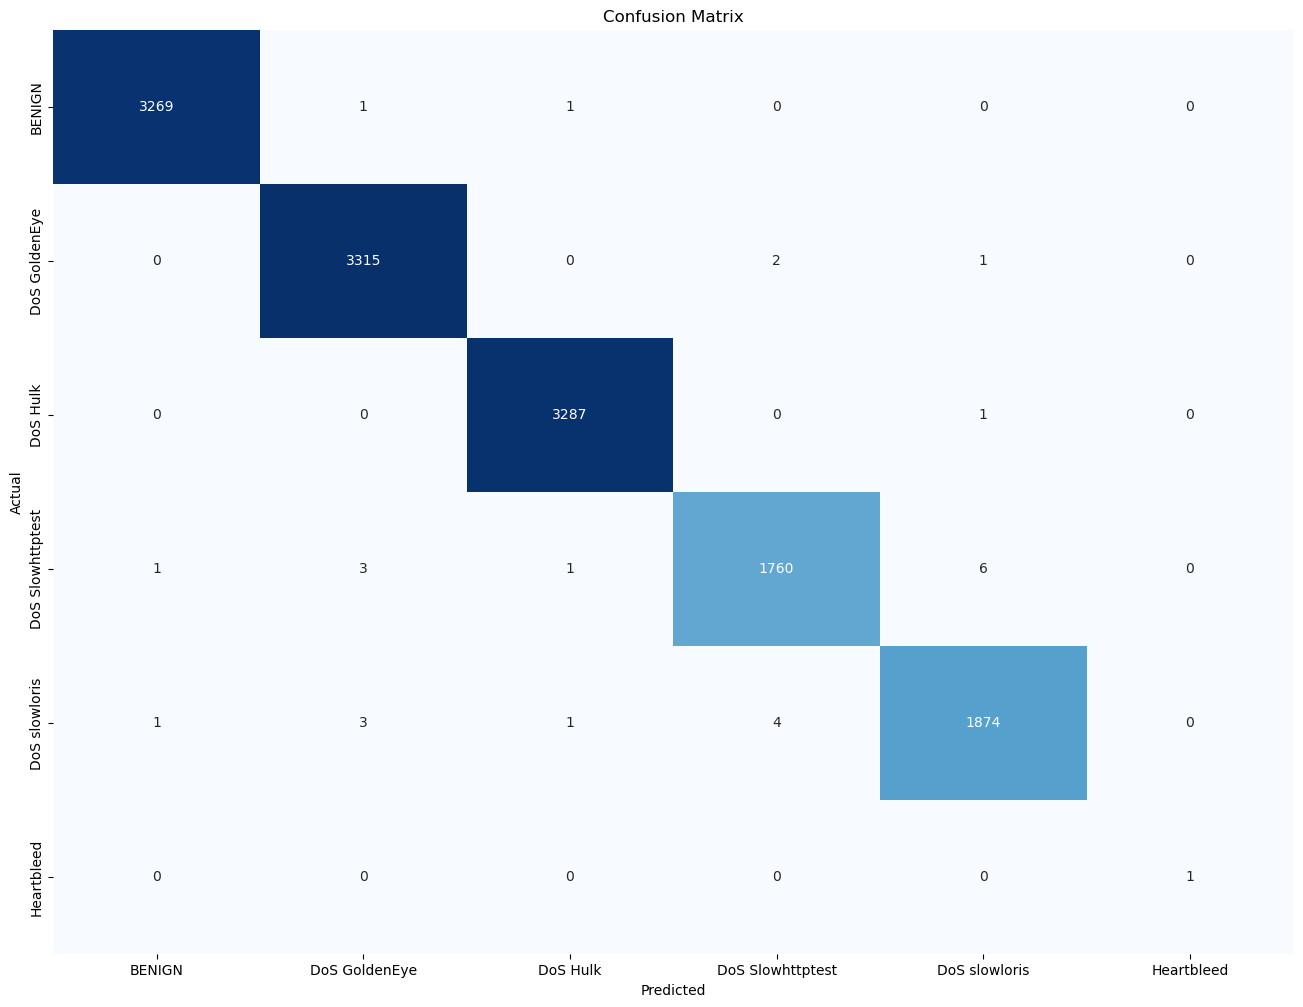

,precision,recall,f1-score,support
BENIGN,0.999389,0.999389,0.999389,3271.000000
DoS GoldenEye,0.997893,0.999096,0.998494,3318.000000
DoS Hulk,0.999088,0.999696,0.999392,3288.000000
DoS Slowhttptest,0.996602,0.993789,0.995194,1771.000000
DoS slowloris,0.995749,0.995220,0.995485,1883.000000
Heartbleed,1.000000,1.000000,1.000000,1.000000
accuracy,0.998079,0.998079,0.998079,0.998079
macro avg,0.998120,0.997865,0.997992,13532.000000
weighted avg,0.998078,0.998079,0.998078,13532.000000


Epoch 0 validation: Cross-entropy=1.51, Accuracy=68.7%
Epoch 1 validation: Cross-entropy=1.48, Accuracy=76.1%
Epoch 2 validation: Cross-entropy=1.45, Accuracy=80.5%
Epoch 3 validation: Cross-entropy=1.41, Accuracy=81.4%
Epoch 4 validation: Cross-entropy=1.37, Accuracy=81.6%
Epoch 5 validation: Cross-entropy=1.33, Accuracy=81.6%
Epoch 6 validation: Cross-entropy=1.28, Accuracy=81.6%
Epoch 7 validation: Cross-entropy=1.23, Accuracy=81.6%
Epoch 8 validation: Cross-entropy=1.17, Accuracy=81.6%
Epoch 9 validation: Cross-entropy=1.11, Accuracy=81.6%
Epoch 10 validation: Cross-entropy=1.04, Accuracy=81.6%
Epoch 11 validation: Cross-entropy=0.97, Accuracy=81.6%
Epoch 12 validation: Cross-entropy=0.90, Accuracy=81.6%
Epoch 13 validation: Cross-entropy=0.82, Accuracy=81.6%
Epoch 14 validation: Cross-entropy=0.75, Accuracy=81.6%
Epoch 15 validation: Cross-entropy=0.69, Accuracy=81.6%
Epoch 16 validation: Cross-entropy=0.63, Accuracy=81.6%
Epoch 17 validation: Cross-entropy=0.58, Accuracy=81.6%
Ep

Epoch 157 validation: Cross-entropy=0.14, Accuracy=95.4%
Epoch 158 validation: Cross-entropy=0.14, Accuracy=95.4%
Epoch 159 validation: Cross-entropy=0.14, Accuracy=95.4%
Epoch 160 validation: Cross-entropy=0.14, Accuracy=95.3%
Epoch 161 validation: Cross-entropy=0.14, Accuracy=95.3%
Epoch 162 validation: Cross-entropy=0.14, Accuracy=95.3%
Epoch 163 validation: Cross-entropy=0.14, Accuracy=95.3%
Epoch 164 validation: Cross-entropy=0.14, Accuracy=95.3%
Epoch 165 validation: Cross-entropy=0.14, Accuracy=95.4%
Epoch 166 validation: Cross-entropy=0.14, Accuracy=95.4%
Epoch 167 validation: Cross-entropy=0.14, Accuracy=95.4%
Epoch 168 validation: Cross-entropy=0.14, Accuracy=95.5%
Epoch 169 validation: Cross-entropy=0.14, Accuracy=95.4%
Epoch 170 validation: Cross-entropy=0.14, Accuracy=95.4%
Epoch 171 validation: Cross-entropy=0.14, Accuracy=95.4%
Epoch 172 validation: Cross-entropy=0.14, Accuracy=95.4%
Epoch 173 validation: Cross-entropy=0.14, Accuracy=95.5%
Epoch 174 validation: Cross-ent

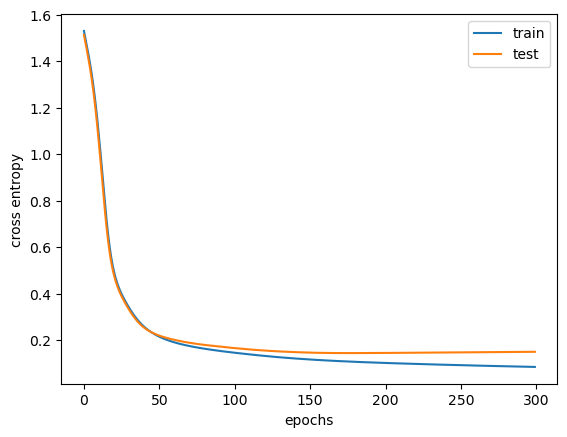

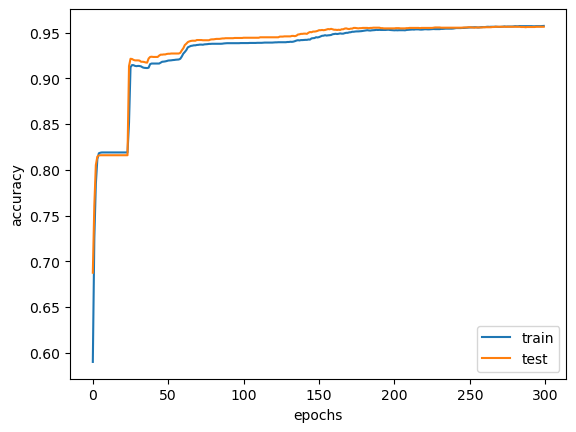

/home/user/anaconda3/envs/linear/lib/python3.8/site-packages/seaborn/utils.py:80: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.draw()
/home/user/anaconda3/envs/linear/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


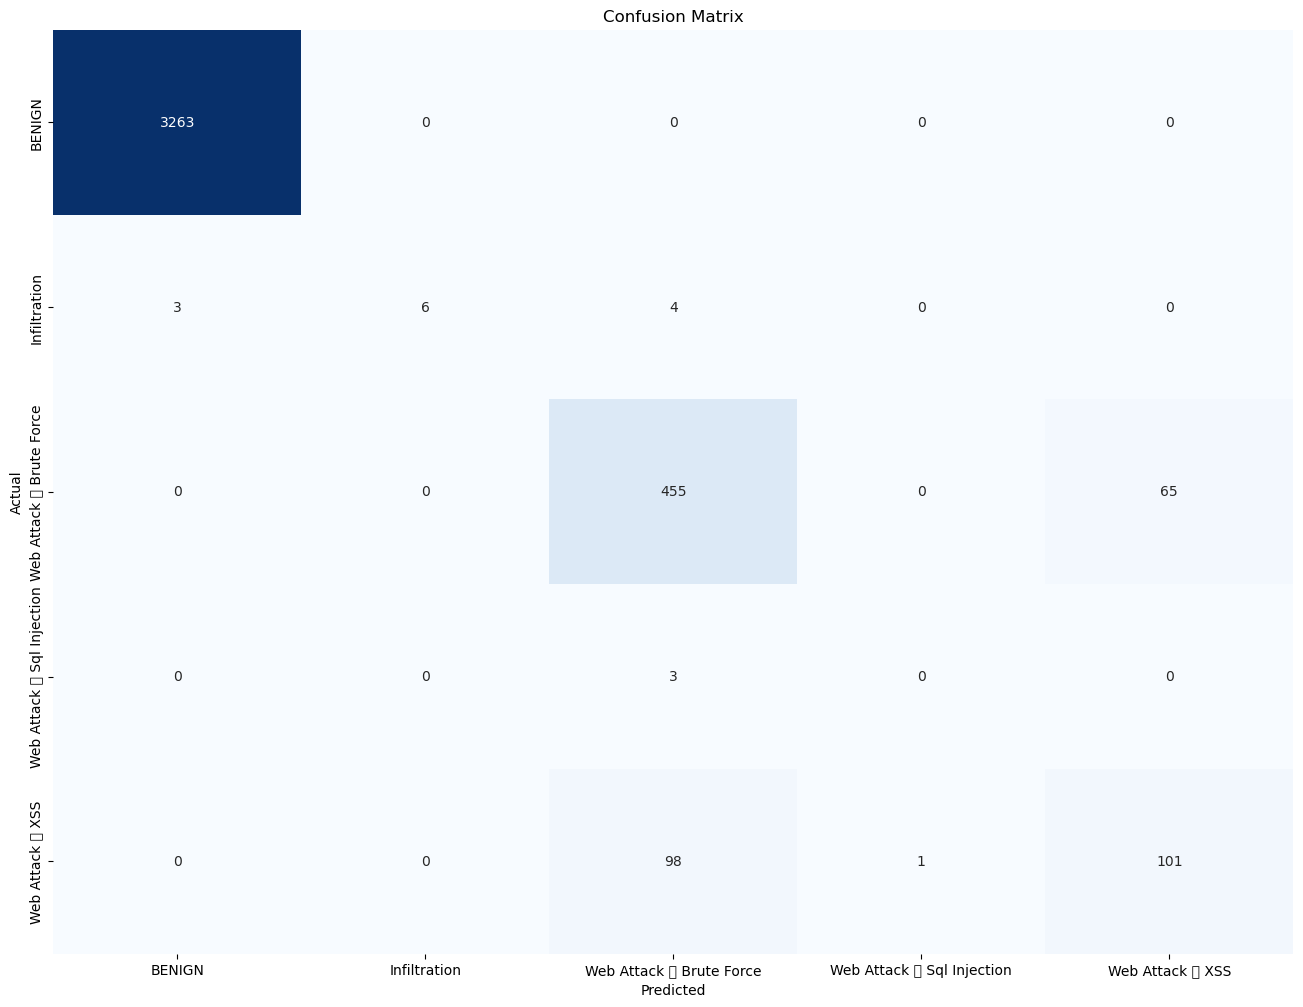

,precision,recall,f1-score,support
BENIGN,0.999081,1.000000,0.999541,3263.000000
Infiltration,1.000000,0.461538,0.631579,13.000000
Web Attack  Brute Force,0.812500,0.875000,0.842593,520.000000
Web Attack  Sql Injection,0.000000,0.000000,0.000000,3.000000
Web Attack  XSS,0.608434,0.505000,0.551913,200.000000
accuracy,0.956489,0.956489,0.956489,0.956489
macro avg,0.684003,0.568308,0.605125,3999.000000
weighted avg,0.954536,0.956489,0.954799,3999.000000


In [35]:
training_model(model=ann_Tue, train_test=Tue)
training_model(model=ann_Wed, train_test=Wed)
training_model(model=ann_Thu, train_test=Thu)

### DNN

Epoch 0 validation: Cross-entropy=0.74, Accuracy=70.1%
Epoch 1 validation: Cross-entropy=0.06, Accuracy=99.1%
Epoch 2 validation: Cross-entropy=0.02, Accuracy=99.2%
Epoch 3 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 4 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 5 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 6 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 7 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 8 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 9 validation: Cross-entropy=0.00, Accuracy=99.8%
Epoch 10 validation: Cross-entropy=0.00, Accuracy=99.8%
Epoch 11 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 12 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 13 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 14 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 15 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 16 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 17 validation: Cross-entropy=0.00, Accuracy=99.9%
Ep

Epoch 149 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 150 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 151 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 152 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 153 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 154 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 155 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 156 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 157 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 158 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 159 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 160 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 161 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 162 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 163 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 164 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 165 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 166 validatio

Epoch 297 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 298 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 299 validation: Cross-entropy=0.00, Accuracy=99.9%


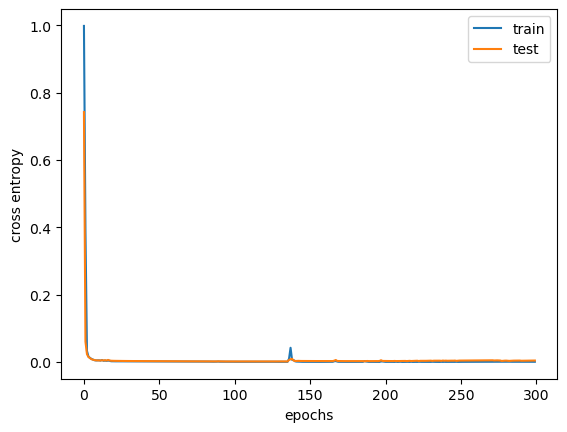

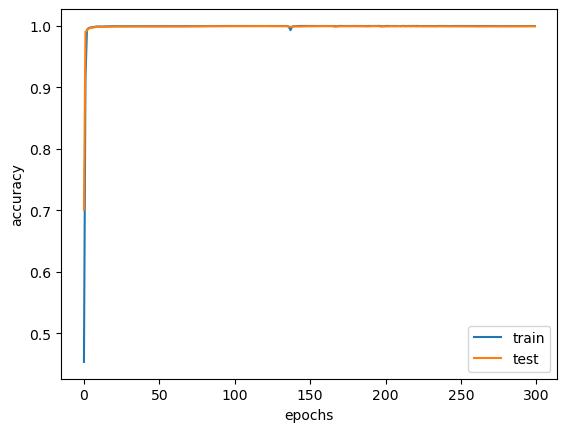

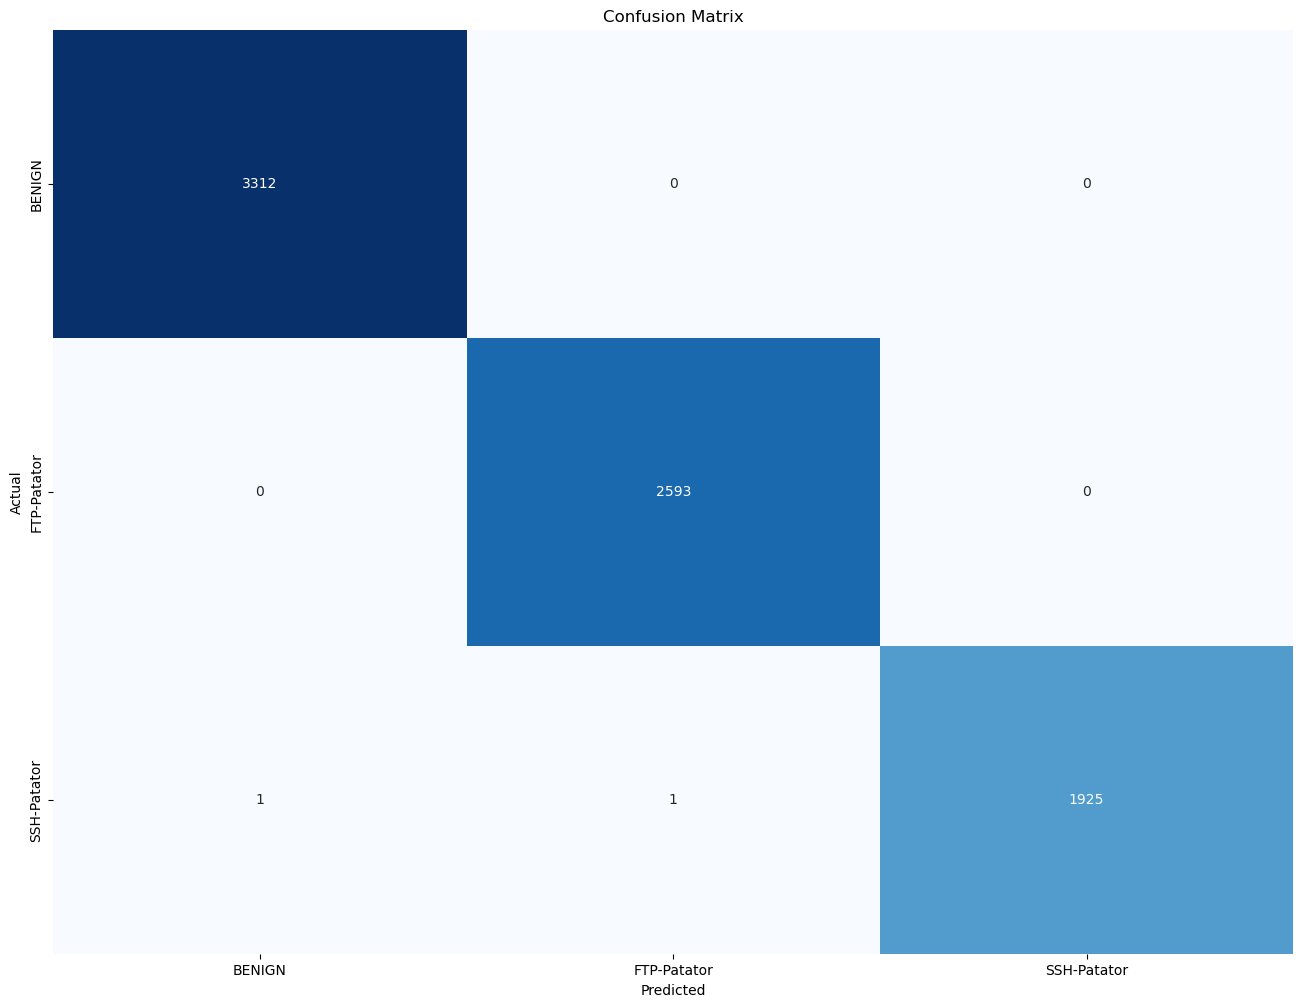

,precision,recall,f1-score,support
BENIGN,0.999698,1.000000,0.999849,3312.000000
FTP-Patator,0.999614,1.000000,0.999807,2593.000000
SSH-Patator,1.000000,0.998962,0.999481,1927.000000
accuracy,0.999745,0.999745,0.999745,0.999745
macro avg,0.999771,0.999654,0.999712,7832.000000
weighted avg,0.999745,0.999745,0.999745,7832.000000


Epoch 0 validation: Cross-entropy=0.49, Accuracy=92.1%
Epoch 1 validation: Cross-entropy=0.06, Accuracy=98.7%
Epoch 2 validation: Cross-entropy=0.03, Accuracy=99.4%
Epoch 3 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 4 validation: Cross-entropy=0.02, Accuracy=99.7%
Epoch 5 validation: Cross-entropy=0.02, Accuracy=99.7%
Epoch 6 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 7 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 8 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 9 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 10 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 11 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 12 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 13 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 14 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 15 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 16 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 17 validation: Cross-entropy=0.01, Accuracy=99.7%
Ep

Epoch 148 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 149 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 150 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 151 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 152 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 153 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 154 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 155 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 156 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 157 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 158 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 159 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 160 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 161 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 162 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 163 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 164 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 165 validation: Cross-ent

Epoch 292 validation: Cross-entropy=0.02, Accuracy=99.9%
Epoch 293 validation: Cross-entropy=0.02, Accuracy=99.9%
Epoch 294 validation: Cross-entropy=0.02, Accuracy=99.9%
Epoch 295 validation: Cross-entropy=0.02, Accuracy=99.9%
Epoch 296 validation: Cross-entropy=0.02, Accuracy=99.9%
Epoch 297 validation: Cross-entropy=0.02, Accuracy=99.9%
Epoch 298 validation: Cross-entropy=0.02, Accuracy=99.9%
Epoch 299 validation: Cross-entropy=0.02, Accuracy=99.9%


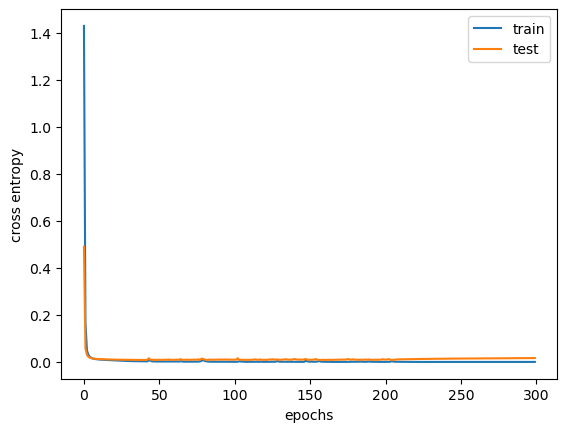

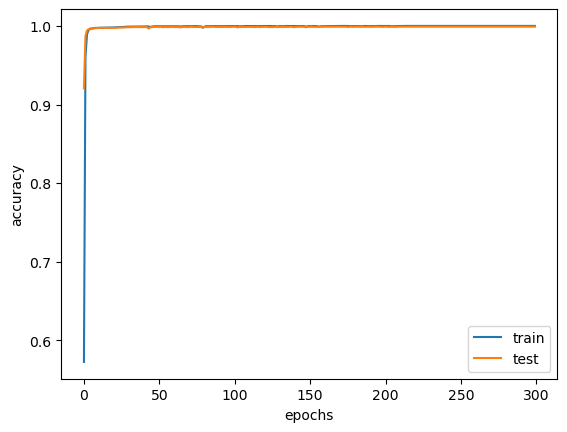

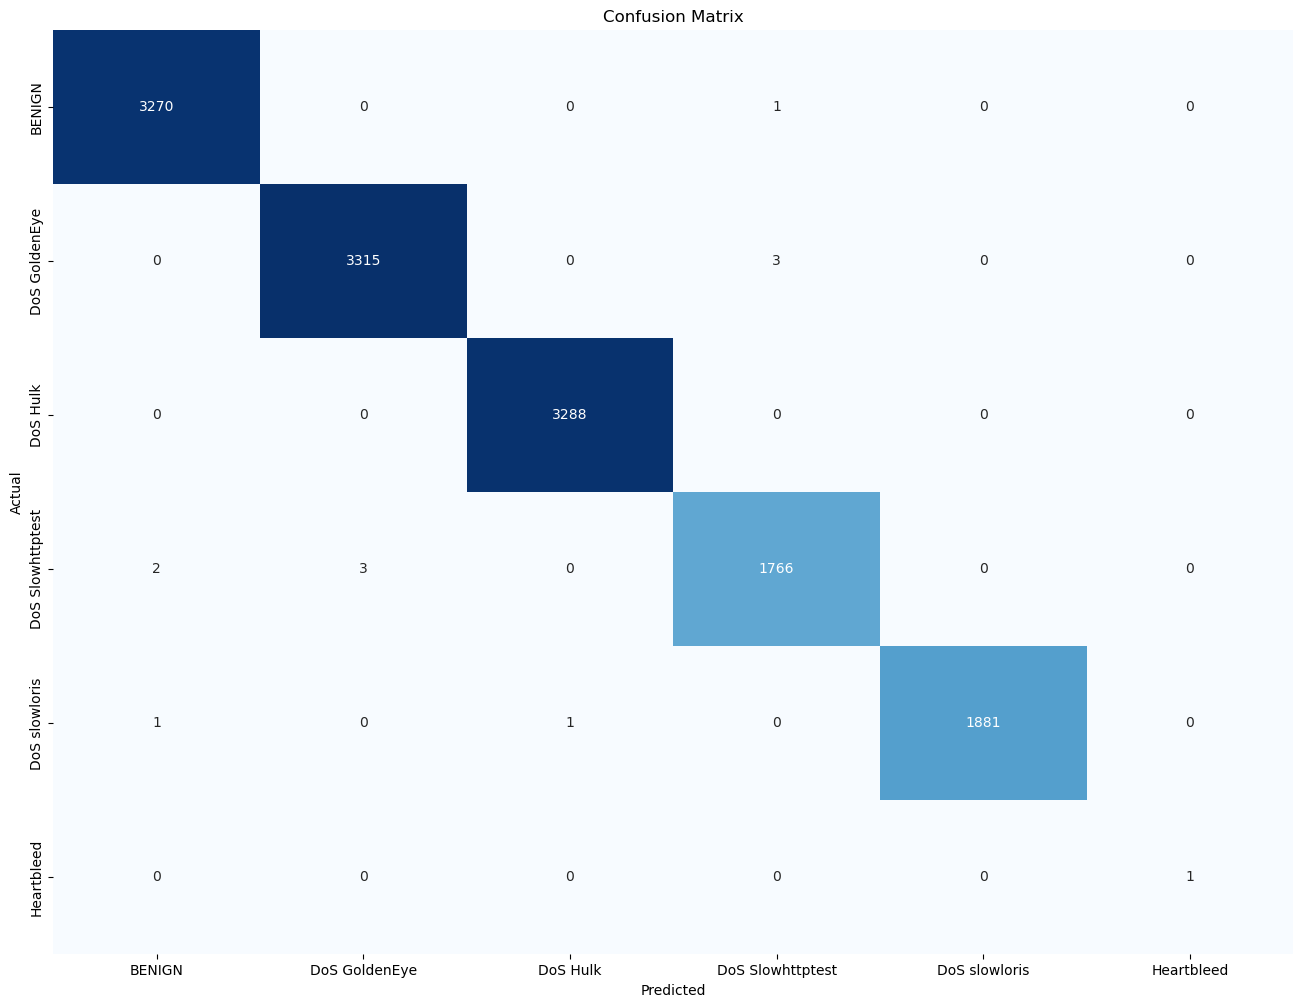

,precision,recall,f1-score,support
BENIGN,0.999083,0.999694,0.999389,3271.000000
DoS GoldenEye,0.999096,0.999096,0.999096,3318.000000
DoS Hulk,0.999696,1.000000,0.999848,3288.000000
DoS Slowhttptest,0.997740,0.997177,0.997458,1771.000000
DoS slowloris,1.000000,0.998938,0.999469,1883.000000
Heartbleed,1.000000,1.000000,1.000000,1.000000
accuracy,0.999187,0.999187,0.999187,0.999187
macro avg,0.999269,0.999151,0.999210,13532.000000
weighted avg,0.999187,0.999187,0.999187,13532.000000


Epoch 0 validation: Cross-entropy=1.41, Accuracy=81.6%
Epoch 1 validation: Cross-entropy=0.71, Accuracy=81.6%
Epoch 2 validation: Cross-entropy=0.51, Accuracy=81.6%
Epoch 3 validation: Cross-entropy=0.44, Accuracy=81.6%
Epoch 4 validation: Cross-entropy=0.40, Accuracy=81.6%
Epoch 5 validation: Cross-entropy=0.35, Accuracy=81.6%
Epoch 6 validation: Cross-entropy=0.30, Accuracy=92.8%
Epoch 7 validation: Cross-entropy=0.24, Accuracy=94.0%
Epoch 8 validation: Cross-entropy=0.19, Accuracy=94.5%
Epoch 9 validation: Cross-entropy=0.16, Accuracy=94.6%
Epoch 10 validation: Cross-entropy=0.15, Accuracy=94.6%
Epoch 11 validation: Cross-entropy=0.14, Accuracy=94.6%
Epoch 12 validation: Cross-entropy=0.14, Accuracy=94.6%
Epoch 13 validation: Cross-entropy=0.13, Accuracy=94.6%
Epoch 14 validation: Cross-entropy=0.13, Accuracy=94.6%
Epoch 15 validation: Cross-entropy=0.12, Accuracy=95.2%
Epoch 16 validation: Cross-entropy=0.13, Accuracy=95.3%
Epoch 17 validation: Cross-entropy=0.13, Accuracy=95.6%
Ep

Epoch 152 validation: Cross-entropy=0.13, Accuracy=96.0%
Epoch 153 validation: Cross-entropy=0.13, Accuracy=96.2%
Epoch 154 validation: Cross-entropy=0.13, Accuracy=96.1%
Epoch 155 validation: Cross-entropy=0.13, Accuracy=96.0%
Epoch 156 validation: Cross-entropy=0.13, Accuracy=96.2%
Epoch 157 validation: Cross-entropy=0.14, Accuracy=96.2%
Epoch 158 validation: Cross-entropy=0.13, Accuracy=96.1%
Epoch 159 validation: Cross-entropy=0.13, Accuracy=96.1%
Epoch 160 validation: Cross-entropy=0.13, Accuracy=96.1%
Epoch 161 validation: Cross-entropy=0.13, Accuracy=96.2%
Epoch 162 validation: Cross-entropy=0.13, Accuracy=96.2%
Epoch 163 validation: Cross-entropy=0.13, Accuracy=96.2%
Epoch 164 validation: Cross-entropy=0.13, Accuracy=96.0%
Epoch 165 validation: Cross-entropy=0.13, Accuracy=96.0%
Epoch 166 validation: Cross-entropy=0.14, Accuracy=96.3%
Epoch 167 validation: Cross-entropy=0.14, Accuracy=96.2%
Epoch 168 validation: Cross-entropy=0.13, Accuracy=96.0%
Epoch 169 validation: Cross-ent

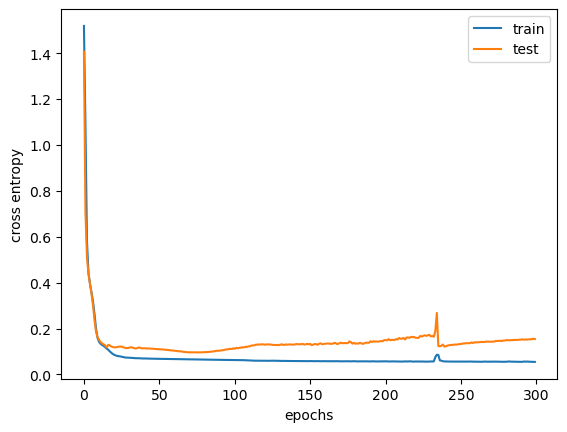

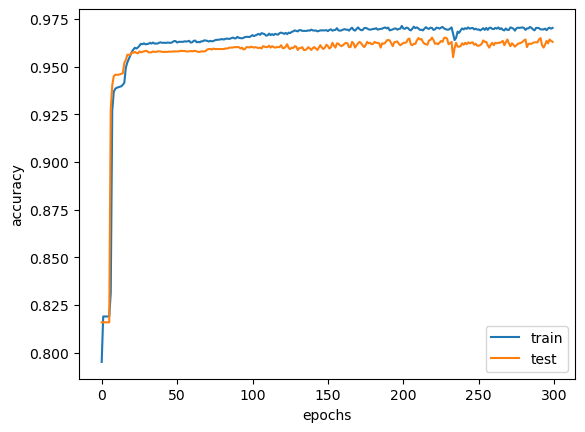

/home/user/anaconda3/envs/linear/lib/python3.8/site-packages/seaborn/utils.py:80: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.draw()
/home/user/anaconda3/envs/linear/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


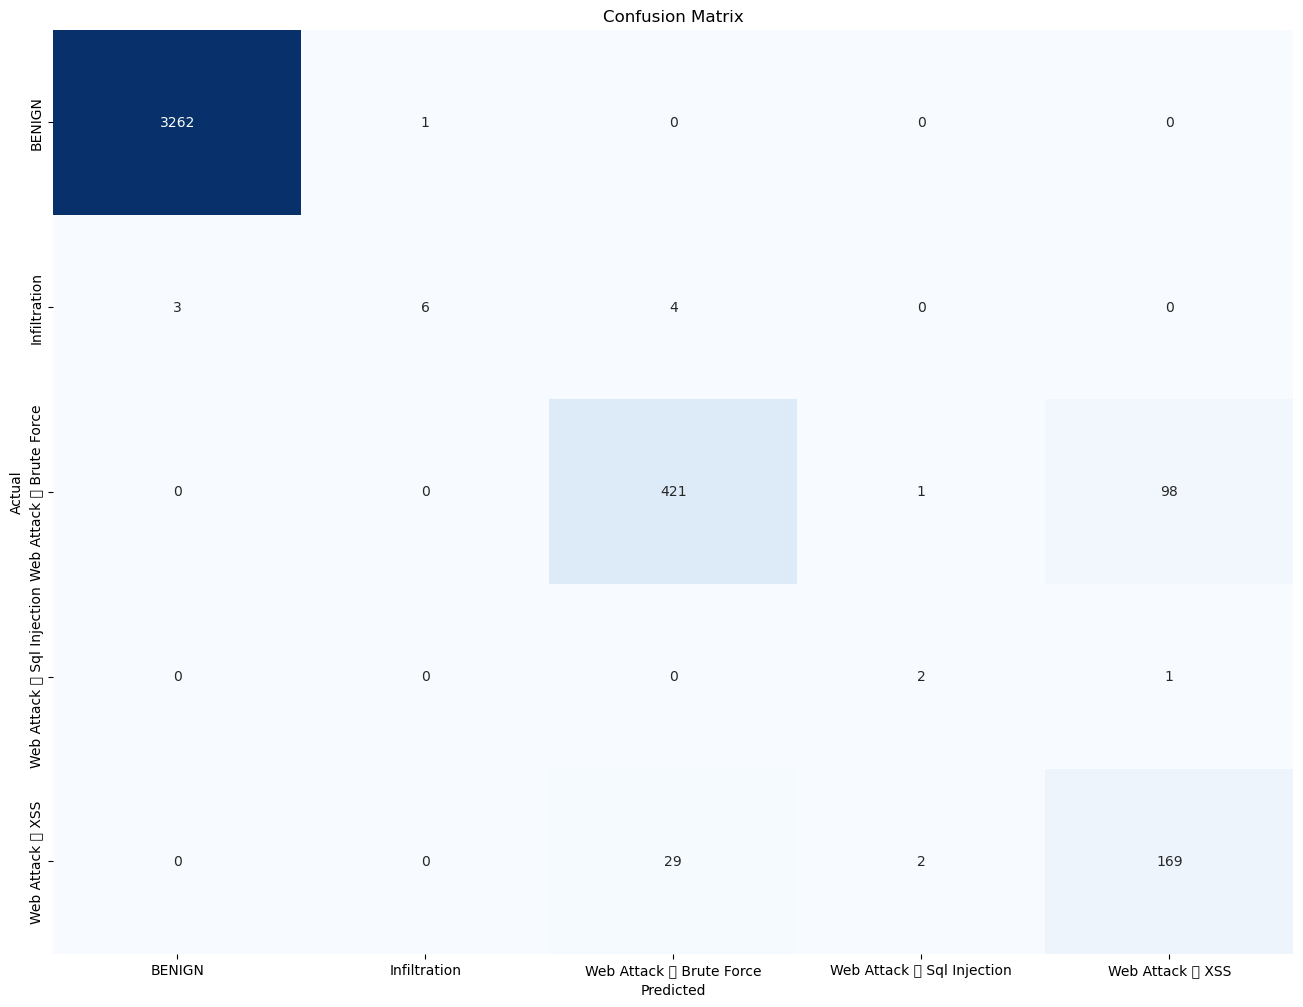

,precision,recall,f1-score,support
BENIGN,0.999081,0.999694,0.999387,3263.000000
Infiltration,0.857143,0.461538,0.600000,13.000000
Web Attack  Brute Force,0.927313,0.809615,0.864476,520.000000
Web Attack  Sql Injection,0.400000,0.666667,0.500000,3.000000
Web Attack  XSS,0.630597,0.845000,0.722222,200.000000
accuracy,0.965241,0.965241,0.965241,0.965241
macro avg,0.762827,0.756503,0.737217,3999.000000
weighted avg,0.970409,0.965241,0.966310,3999.000000


In [36]:
training_model(model=dnn_Tue, train_test=Tue)
training_model(model=dnn_Wed, train_test=Wed)
training_model(model=dnn_Thu, train_test=Thu)

### MLP

Epoch 0 validation: Cross-entropy=1.07, Accuracy=44.5%
Epoch 1 validation: Cross-entropy=1.03, Accuracy=56.3%
Epoch 2 validation: Cross-entropy=0.97, Accuracy=65.3%
Epoch 3 validation: Cross-entropy=0.91, Accuracy=70.0%
Epoch 4 validation: Cross-entropy=0.84, Accuracy=72.1%
Epoch 5 validation: Cross-entropy=0.76, Accuracy=75.0%
Epoch 6 validation: Cross-entropy=0.68, Accuracy=84.7%
Epoch 7 validation: Cross-entropy=0.60, Accuracy=91.6%
Epoch 8 validation: Cross-entropy=0.52, Accuracy=97.9%
Epoch 9 validation: Cross-entropy=0.44, Accuracy=98.9%
Epoch 10 validation: Cross-entropy=0.36, Accuracy=98.8%
Epoch 11 validation: Cross-entropy=0.29, Accuracy=98.8%
Epoch 12 validation: Cross-entropy=0.23, Accuracy=98.8%
Epoch 13 validation: Cross-entropy=0.18, Accuracy=98.8%
Epoch 14 validation: Cross-entropy=0.14, Accuracy=98.8%
Epoch 15 validation: Cross-entropy=0.11, Accuracy=98.8%
Epoch 16 validation: Cross-entropy=0.09, Accuracy=98.8%
Epoch 17 validation: Cross-entropy=0.07, Accuracy=98.7%
Ep

Epoch 151 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 152 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 153 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 154 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 155 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 156 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 157 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 158 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 159 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 160 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 161 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 162 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 163 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 164 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 165 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 166 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 167 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 168 validation: Cross-ent

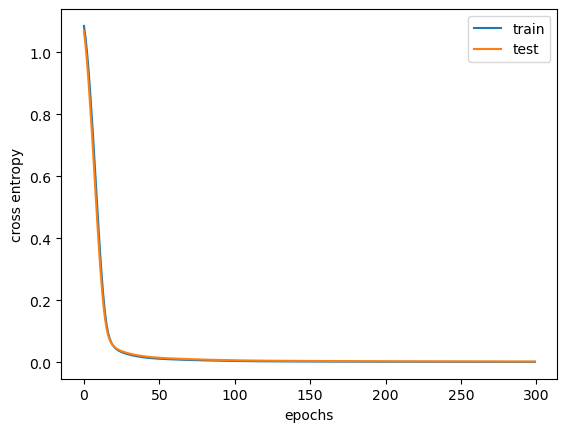

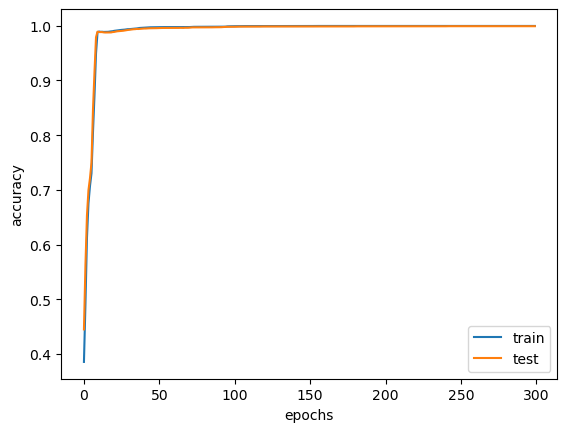

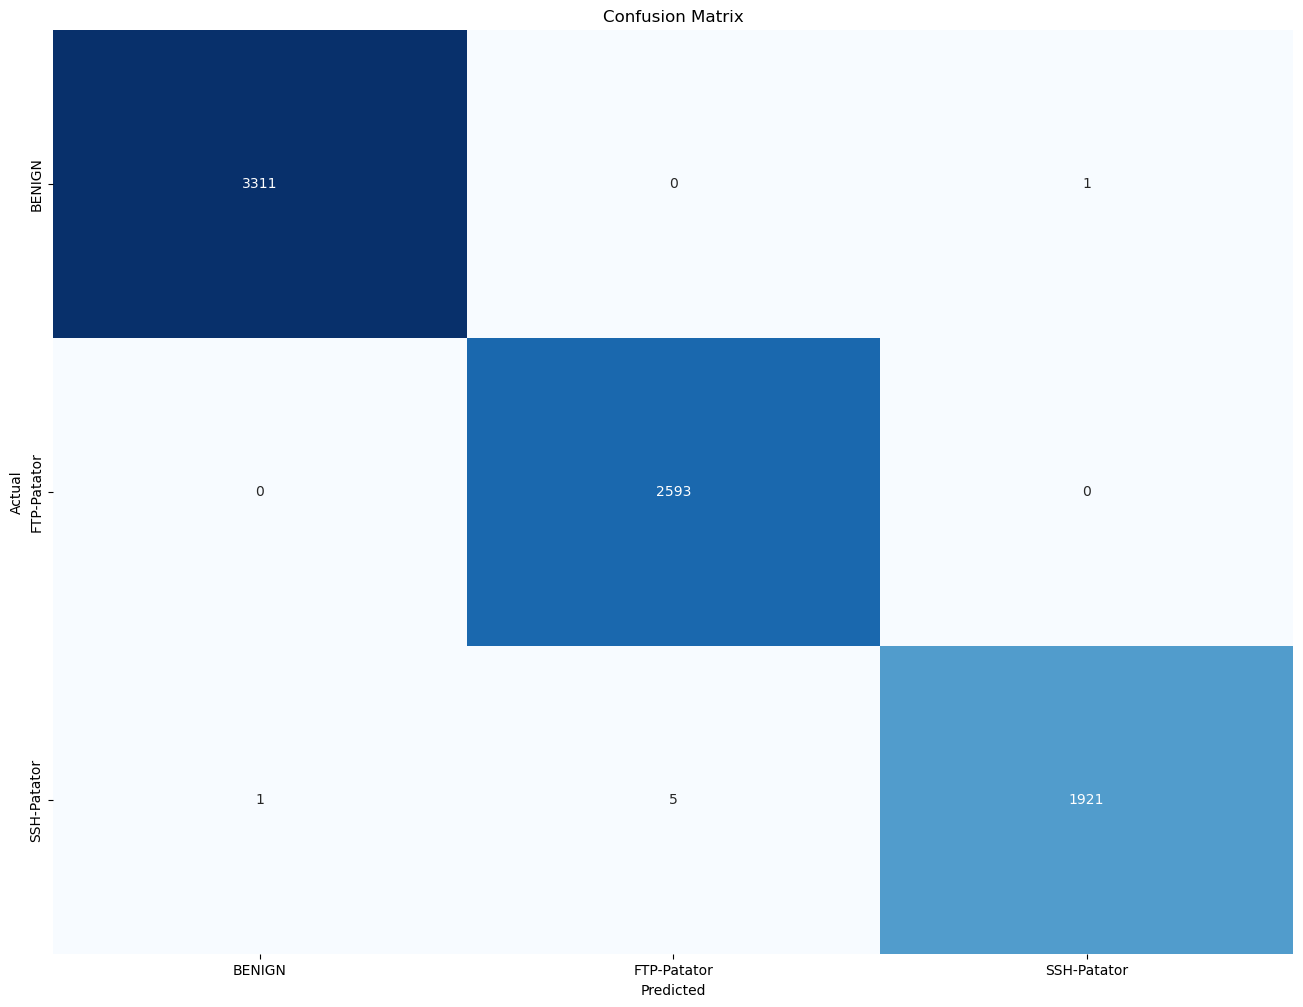

,precision,recall,f1-score,support
BENIGN,0.999698,0.999698,0.999698,3312.000000
FTP-Patator,0.998075,1.000000,0.999037,2593.000000
SSH-Patator,0.999480,0.996886,0.998181,1927.000000
accuracy,0.999106,0.999106,0.999106,0.999106
macro avg,0.999084,0.998861,0.998972,7832.000000
weighted avg,0.999107,0.999106,0.999106,7832.000000


Epoch 0 validation: Cross-entropy=1.74, Accuracy=37.3%
Epoch 1 validation: Cross-entropy=1.67, Accuracy=40.4%
Epoch 2 validation: Cross-entropy=1.56, Accuracy=49.5%
Epoch 3 validation: Cross-entropy=1.35, Accuracy=74.3%
Epoch 4 validation: Cross-entropy=1.07, Accuracy=78.5%
Epoch 5 validation: Cross-entropy=0.81, Accuracy=82.4%
Epoch 6 validation: Cross-entropy=0.61, Accuracy=87.9%
Epoch 7 validation: Cross-entropy=0.46, Accuracy=91.8%
Epoch 8 validation: Cross-entropy=0.35, Accuracy=93.1%
Epoch 9 validation: Cross-entropy=0.27, Accuracy=94.1%
Epoch 10 validation: Cross-entropy=0.22, Accuracy=95.6%
Epoch 11 validation: Cross-entropy=0.18, Accuracy=96.4%
Epoch 12 validation: Cross-entropy=0.15, Accuracy=96.9%
Epoch 13 validation: Cross-entropy=0.13, Accuracy=97.7%
Epoch 14 validation: Cross-entropy=0.12, Accuracy=98.0%
Epoch 15 validation: Cross-entropy=0.10, Accuracy=98.2%
Epoch 16 validation: Cross-entropy=0.09, Accuracy=98.6%
Epoch 17 validation: Cross-entropy=0.08, Accuracy=98.7%
Ep

Epoch 148 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 149 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 150 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 151 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 152 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 153 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 154 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 155 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 156 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 157 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 158 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 159 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 160 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 161 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 162 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 163 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 164 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 165 validation: Cross-ent

Epoch 294 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 295 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 296 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 297 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 298 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 299 validation: Cross-entropy=0.01, Accuracy=99.8%


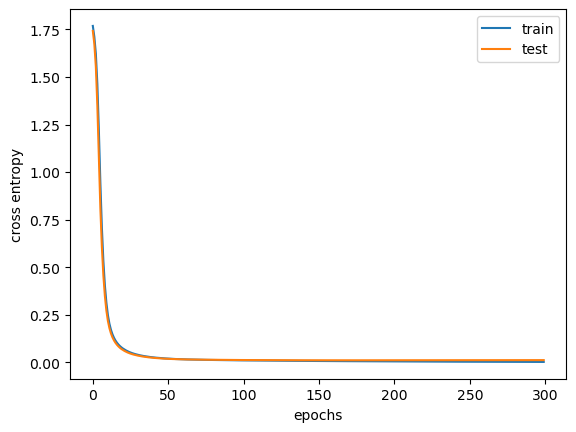

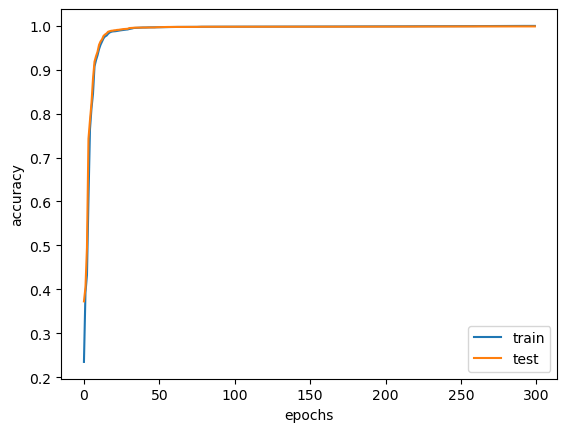

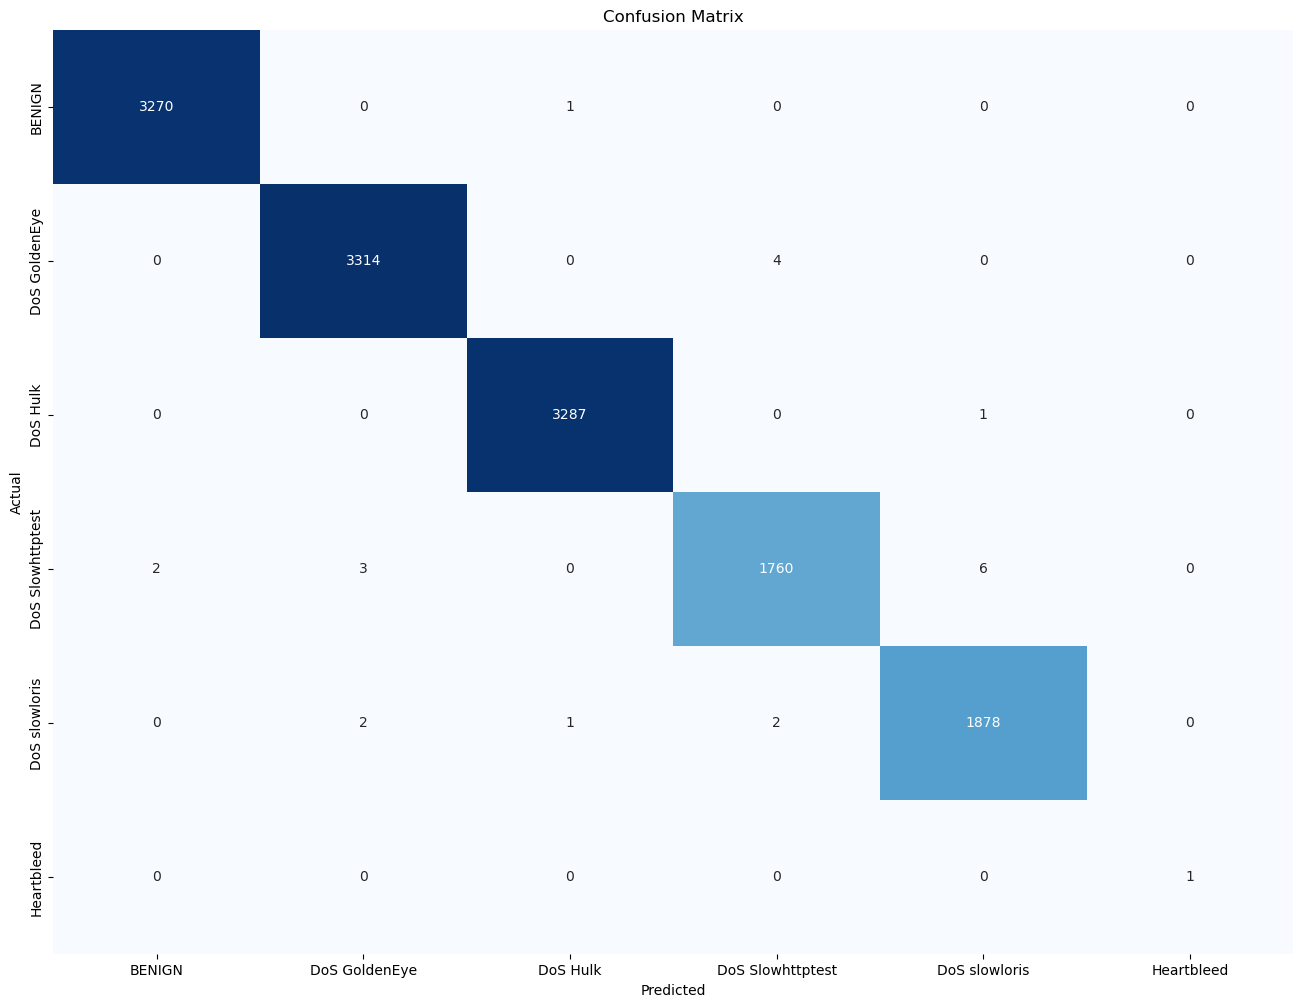

,precision,recall,f1-score,support
BENIGN,0.999389,0.999694,0.999541,3271.000000
DoS GoldenEye,0.998494,0.998794,0.998644,3318.000000
DoS Hulk,0.999392,0.999696,0.999544,3288.000000
DoS Slowhttptest,0.996602,0.993789,0.995194,1771.000000
DoS slowloris,0.996286,0.997345,0.996815,1883.000000
Heartbleed,1.000000,1.000000,1.000000,1.000000
accuracy,0.998374,0.998374,0.998374,0.998374
macro avg,0.998361,0.998220,0.998290,13532.000000
weighted avg,0.998374,0.998374,0.998374,13532.000000


Epoch 0 validation: Cross-entropy=1.66, Accuracy=0.3%
Epoch 1 validation: Cross-entropy=1.64, Accuracy=1.7%
Epoch 2 validation: Cross-entropy=1.62, Accuracy=5.0%
Epoch 3 validation: Cross-entropy=1.59, Accuracy=8.6%
Epoch 4 validation: Cross-entropy=1.57, Accuracy=14.1%
Epoch 5 validation: Cross-entropy=1.54, Accuracy=22.8%
Epoch 6 validation: Cross-entropy=1.50, Accuracy=40.3%
Epoch 7 validation: Cross-entropy=1.45, Accuracy=79.7%
Epoch 8 validation: Cross-entropy=1.39, Accuracy=81.6%
Epoch 9 validation: Cross-entropy=1.32, Accuracy=81.6%
Epoch 10 validation: Cross-entropy=1.23, Accuracy=81.6%
Epoch 11 validation: Cross-entropy=1.13, Accuracy=81.6%
Epoch 12 validation: Cross-entropy=1.03, Accuracy=81.6%
Epoch 13 validation: Cross-entropy=0.91, Accuracy=81.6%
Epoch 14 validation: Cross-entropy=0.79, Accuracy=81.6%
Epoch 15 validation: Cross-entropy=0.69, Accuracy=81.6%
Epoch 16 validation: Cross-entropy=0.61, Accuracy=81.6%
Epoch 17 validation: Cross-entropy=0.55, Accuracy=81.6%
Epoch 

Epoch 166 validation: Cross-entropy=0.12, Accuracy=95.5%
Epoch 167 validation: Cross-entropy=0.12, Accuracy=95.5%
Epoch 168 validation: Cross-entropy=0.12, Accuracy=95.5%
Epoch 169 validation: Cross-entropy=0.12, Accuracy=95.5%
Epoch 170 validation: Cross-entropy=0.12, Accuracy=95.6%
Epoch 171 validation: Cross-entropy=0.12, Accuracy=95.6%
Epoch 172 validation: Cross-entropy=0.12, Accuracy=95.6%
Epoch 173 validation: Cross-entropy=0.12, Accuracy=95.6%
Epoch 174 validation: Cross-entropy=0.12, Accuracy=95.6%
Epoch 175 validation: Cross-entropy=0.12, Accuracy=95.6%
Epoch 176 validation: Cross-entropy=0.12, Accuracy=95.6%
Epoch 177 validation: Cross-entropy=0.12, Accuracy=95.6%
Epoch 178 validation: Cross-entropy=0.12, Accuracy=95.6%
Epoch 179 validation: Cross-entropy=0.12, Accuracy=95.6%
Epoch 180 validation: Cross-entropy=0.12, Accuracy=95.6%
Epoch 181 validation: Cross-entropy=0.12, Accuracy=95.6%
Epoch 182 validation: Cross-entropy=0.12, Accuracy=95.6%
Epoch 183 validation: Cross-ent

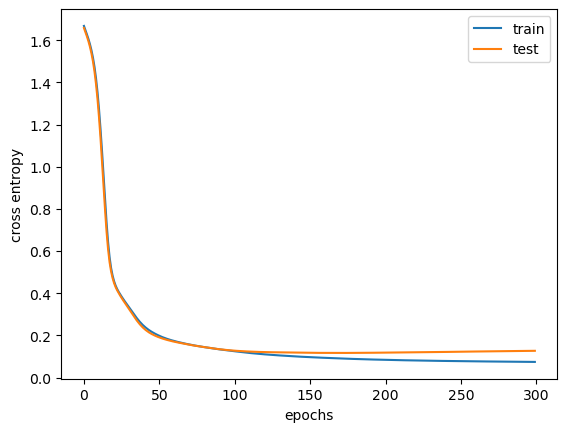

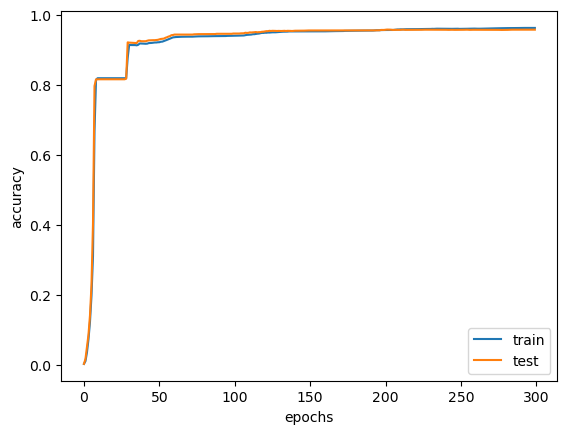

/home/user/anaconda3/envs/linear/lib/python3.8/site-packages/seaborn/utils.py:80: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.draw()
/home/user/anaconda3/envs/linear/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


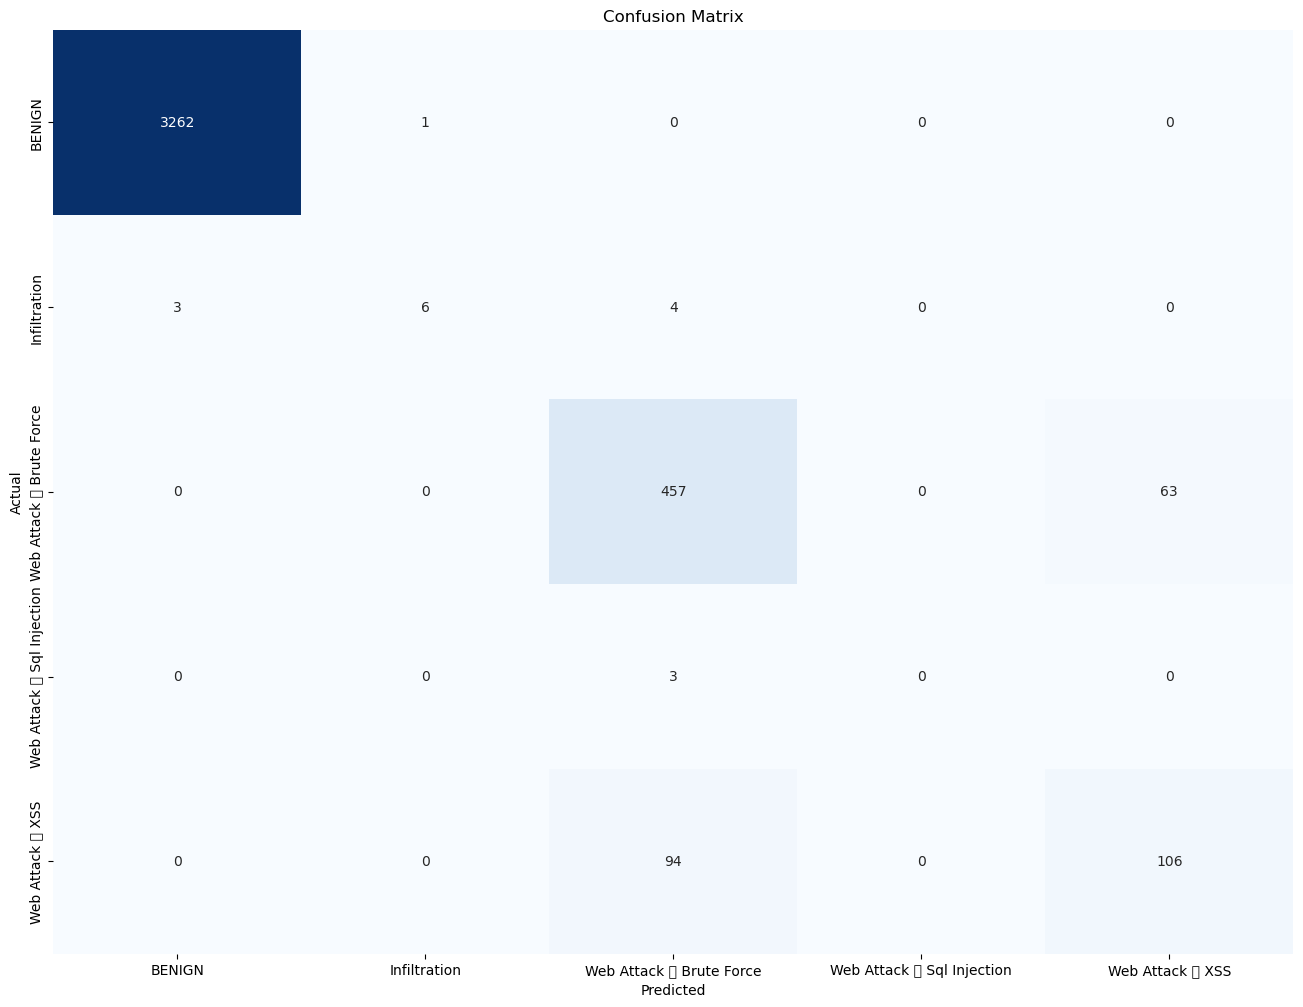

/home/user/anaconda3/envs/linear/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user/anaconda3/envs/linear/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user/anaconda3/envs/linear/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
BENIGN,0.999081,0.999694,0.999387,3263.000000
Infiltration,0.857143,0.461538,0.600000,13.000000
Web Attack  Brute Force,0.818996,0.878846,0.847866,520.000000
Web Attack  Sql Injection,0.000000,0.000000,0.000000,3.000000
Web Attack  XSS,0.627219,0.530000,0.574526,200.000000
accuracy,0.957989,0.957989,0.957989,0.957989
macro avg,0.660488,0.574016,0.604356,3999.000000
weighted avg,0.955856,0.957989,0.956388,3999.000000


In [37]:
training_model(model=mlp_Tue, train_test=Tue)
training_model(model=mlp_Wed, train_test=Wed)
training_model(model=mlp_Thu, train_test=Thu)